# 📊 Notebook 5: Dead Stock Analysis Module

## 🎯 Purpose
Comprehensive analysis of DEAD STOCK items with age-based liquidation strategies, root cause analysis, and recovery planning.

## 📥 Input
- **File**: `dbscan_classification.pkl` (from Notebook 2)
- **Filter**: `classification == 'DEAD_STOCK'`

## 📤 Output
- **File**: `dead_stock_complete.csv` ⭐ (Complete dead stock analysis)
- **File**: `dead_stock_complete.pkl` (Faster loading)
- **File**: `liquidation_plan_priority.csv` (Sorted by recovery potential)
- **File**: `write_off_candidates.csv` (Items < ₹100 value)
- **File**: `dead_stock_root_causes.csv` (Why items died)
- **File**: `dead_stock_summary_report.csv` (Executive summary)
- **File**: `dead_stock_action_plan.csv` (Month-by-month plan)
- **File**: `dead_stock_dashboard.png` (Comprehensive visualizations)

## 💀 Dead Stock Definition
Items with:
- No sales for 180+ days (6 months)
- OR never sold AND > 90 days old

## 💰 Liquidation Strategy Framework

### Age-Based Discounting:
```python
Age 0-1 years:   20% discount → 80% recovery → 3 months
Age 1-2 years:   30% discount → 70% recovery → 3 months
Age 2-4 years:   50% discount → 50% recovery → 6 months
Age 4+ years:    70% discount → 30% recovery → 6 months
Value < ₹100:    100% write-off → 0% recovery → Immediate
```

### Priority Ranking:
```python
Priority = (recovery_value × recency_factor) / holding_cost

Where:
- recovery_value = stock_value × recovery_percentage
- recency_factor = 1.0 for age < 2y, 0.7 for 2-4y, 0.4 for 4+y
- holding_cost = stock_value × 0.25 × (age_years / 12)
```

In [2]:
# 📚 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1️⃣ Load Classified Data

In [3]:
# Load classified data from Notebook 2
try:
    print("⏳ Loading classified data from pickle...")
    df = pd.read_pickle('/tmp/dbscan_classification.pkl')
    print("✅ Loaded from pickle")
except FileNotFoundError:
    print("⏳ Pickle not found, loading from CSV...")
    df = pd.read_csv('/tmp/dbscan_classification.csv')
    print("✅ Loaded from CSV")

print(f"\n📊 Total items in dataset: {len(df):,}")

# Filter DEAD_STOCK only
dead_stock = df[df['classification'] == 'DEAD_STOCK'].copy()

print(f"\n💀 DEAD STOCK Found: {len(dead_stock):,}")

if len(dead_stock) == 0:
    print("\n✅ Excellent! No dead stock found!")
    print("   Your inventory is healthy.")
else:
    dead_pct = len(dead_stock) / len(df) * 100
    total_value = dead_stock['stock_value'].sum()
    
    print(f"\n   Percentage of total: {dead_pct:.1f}%")
    print(f"   Total stock value: ₹{total_value:,.0f}")
    print(f"   Avg days no sale: {dead_stock['days_since_last_sale'].mean():.0f} days")
    print(f"   Avg age: {dead_stock['days_since_creation'].mean():.0f} days")
    print(f"\n⚠️ This represents significant capital tied up in non-moving inventory!")

⏳ Loading classified data from pickle...
✅ Loaded from pickle

📊 Total items in dataset: 13,489

💀 DEAD STOCK Found: 11,480

   Percentage of total: 85.1%
   Total stock value: ₹1,345,238
   Avg days no sale: 945 days
   Avg age: 777 days

⚠️ This represents significant capital tied up in non-moving inventory!


## 2️⃣ Calculate Item Age Analysis

### Age Categories:
- **RECENT** (0-1 years): Recent dead stock
- **AGING** (1-2 years): Getting old
- **OLD** (2-4 years): Very old
- **ANCIENT** (4+ years): Ancient inventory

In [4]:
if len(dead_stock) > 0:
    # Calculate item age in years
    dead_stock['item_age_years'] = dead_stock['days_since_creation'] / 365
    
    # Age bracket classification
    def get_age_bracket(age_years):
        if age_years < 1:
            return 'RECENT'
        elif age_years < 2:
            return 'AGING'
        elif age_years < 4:
            return 'OLD'
        else:
            return 'ANCIENT'
    
    dead_stock['age_bracket'] = dead_stock['item_age_years'].apply(get_age_bracket)
    
    print("\n📊 AGE ANALYSIS:\n")
    print(dead_stock['age_bracket'].value_counts())
    print()
    
    for bracket in ['RECENT', 'AGING', 'OLD', 'ANCIENT']:
        subset = dead_stock[dead_stock['age_bracket'] == bracket]
        if len(subset) > 0:
            pct = len(subset) / len(dead_stock) * 100
            value = subset['stock_value'].sum()
            avg_age = subset['item_age_years'].mean()
            
            print(f"{bracket:10s}: {len(subset):5,} items ({pct:5.1f}%) - Value: ₹{value:,.0f} - Avg: {avg_age:.1f}y")


📊 AGE ANALYSIS:

age_bracket
OLD        8482
AGING      2038
RECENT      932
ANCIENT      28
Name: count, dtype: int64

RECENT    :   932 items (  8.1%) - Value: ₹344,050 - Avg: 0.8y
AGING     : 2,038 items ( 17.8%) - Value: ₹116,001 - Avg: 1.6y
OLD       : 8,482 items ( 73.9%) - Value: ₹834,722 - Avg: 2.4y
ANCIENT   :    28 items (  0.2%) - Value: ₹50,464 - Avg: 4.2y


## 3️⃣ Value-Based Segmentation

### Value Categories:
- **WRITE_OFF** (< ₹100): Not worth recovery effort
- **LOW_VALUE** (₹100-1,000): Bulk liquidation
- **MEDIUM_VALUE** (₹1,000-10,000): Standard liquidation
- **HIGH_VALUE** (₹10,000+): Priority recovery

In [5]:
if len(dead_stock) > 0:
    def get_value_category(stock_value):
        if stock_value < 100:
            return 'WRITE_OFF'
        elif stock_value < 1000:
            return 'LOW_VALUE'
        elif stock_value < 10000:
            return 'MEDIUM_VALUE'
        else:
            return 'HIGH_VALUE'
    
    dead_stock['value_category'] = dead_stock['stock_value'].apply(get_value_category)
    
    print("\n📊 VALUE SEGMENTATION:\n")
    print(dead_stock['value_category'].value_counts())
    print()
    
    for category in ['HIGH_VALUE', 'MEDIUM_VALUE', 'LOW_VALUE', 'WRITE_OFF']:
        subset = dead_stock[dead_stock['value_category'] == category]
        if len(subset) > 0:
            pct = len(subset) / len(dead_stock) * 100
            value = subset['stock_value'].sum()
            value_pct = value / dead_stock['stock_value'].sum() * 100
            
            print(f"{category:15s}: {len(subset):5,} items ({pct:5.1f}%) - Value: ₹{value:,.0f} ({value_pct:.1f}% of total)")


📊 VALUE SEGMENTATION:

value_category
WRITE_OFF       10392
LOW_VALUE         866
MEDIUM_VALUE      205
HIGH_VALUE         17
Name: count, dtype: int64

HIGH_VALUE     :    17 items (  0.1%) - Value: ₹531,610 (39.5% of total)
MEDIUM_VALUE   :   205 items (  1.8%) - Value: ₹522,524 (38.8% of total)
LOW_VALUE      :   866 items (  7.5%) - Value: ₹247,938 (18.4% of total)
WRITE_OFF      : 10,392 items ( 90.5%) - Value: ₹43,166 (3.2% of total)


## 4️⃣ Determine Liquidation Strategy

### Strategy Matrix:
```
Age 0-1y:   DISCOUNT_20  → 80% recovery → 3 months
Age 1-2y:   DISCOUNT_30  → 70% recovery → 3 months
Age 2-4y:   DISCOUNT_50  → 50% recovery → 6 months
Age 4+y:    DISCOUNT_70  → 30% recovery → 6 months
< ₹100:     WRITE_OFF    → 0% recovery  → Immediate
```

In [6]:
if len(dead_stock) > 0:
    def determine_liquidation_strategy(row):
        """
        Determine liquidation strategy based on age and value
        """
        age_years = row['item_age_years']
        stock_value = row['stock_value']
        
        # Write-off if value too low
        if stock_value < 100:
            return {
                'strategy': 'WRITE_OFF',
                'discount_pct': 100,
                'recovery_pct': 0,
                'timeframe_months': 0,
                'method': 'Dispose/Donate'
            }
        
        # Age-based strategies
        elif age_years < 1:
            return {
                'strategy': 'DISCOUNT_20',
                'discount_pct': 20,
                'recovery_pct': 80,
                'timeframe_months': 3,
                'method': 'Online sale / Clearance'
            }
        
        elif age_years < 2:
            return {
                'strategy': 'DISCOUNT_30',
                'discount_pct': 30,
                'recovery_pct': 70,
                'timeframe_months': 3,
                'method': 'Promotional sale'
            }
        
        elif age_years < 4:
            return {
                'strategy': 'DISCOUNT_50',
                'discount_pct': 50,
                'recovery_pct': 50,
                'timeframe_months': 6,
                'method': 'Deep discount sale'
            }
        
        else:  # 4+ years
            return {
                'strategy': 'DISCOUNT_70',
                'discount_pct': 70,
                'recovery_pct': 30,
                'timeframe_months': 6,
                'method': 'Fire sale / Bulk liquidation'
            }
    
    # Apply strategy determination
    strategy_data = dead_stock.apply(determine_liquidation_strategy, axis=1, result_type='expand')
    dead_stock = pd.concat([dead_stock, strategy_data], axis=1)
    
    # Calculate expected recovery
    dead_stock['expected_recovery'] = dead_stock['stock_value'] * (dead_stock['recovery_pct'] / 100)
    dead_stock['potential_loss'] = dead_stock['stock_value'] - dead_stock['expected_recovery']
    
    print("\n✅ Liquidation strategies determined")
    print(f"\n📊 Strategy Distribution:\n")
    print(dead_stock['strategy'].value_counts())
    print()
    
    for strategy in ['DISCOUNT_20', 'DISCOUNT_30', 'DISCOUNT_50', 'DISCOUNT_70', 'WRITE_OFF']:
        subset = dead_stock[dead_stock['strategy'] == strategy]
        if len(subset) > 0:
            count = len(subset)
            total_value = subset['stock_value'].sum()
            recovery = subset['expected_recovery'].sum()
            recovery_pct = subset['recovery_pct'].iloc[0]
            
            print(f"{strategy:15s}: {count:5,} items - Value: ₹{total_value:,.0f} → Recovery: ₹{recovery:,.0f} ({recovery_pct}%)")


✅ Liquidation strategies determined

📊 Strategy Distribution:

strategy
WRITE_OFF      10392
DISCOUNT_50      824
DISCOUNT_30      180
DISCOUNT_20       78
DISCOUNT_70        6
Name: count, dtype: int64

DISCOUNT_20    :    78 items - Value: ₹341,259 → Recovery: ₹273,007 (80%)
DISCOUNT_30    :   180 items - Value: ₹105,065 → Recovery: ₹73,546 (70%)
DISCOUNT_50    :   824 items - Value: ₹805,284 → Recovery: ₹402,642 (50%)
DISCOUNT_70    :     6 items - Value: ₹50,464 → Recovery: ₹15,139 (30%)
WRITE_OFF      : 10,392 items - Value: ₹43,166 → Recovery: ₹0 (0%)


## 5️⃣ Calculate Liquidation Priority

### Priority Formula:
```python
priority_score = (recovery_value × urgency_factor) / holding_cost_rate

Where:
- urgency_factor = 1.0 (age < 2y), 0.7 (2-4y), 0.4 (4+y)
- holding_cost_rate = 0.25 (25% per year)
```

### Priority Levels:
1. **URGENT**: High value, high recovery potential
2. **HIGH**: Good recovery potential
3. **MEDIUM**: Moderate recovery
4. **LOW**: Low recovery potential
5. **WRITE_OFF**: Not worth effort

In [7]:
if len(dead_stock) > 0:
    def calculate_liquidation_priority(row):
        """
        Calculate priority score for liquidation
        """
        age_years = row['item_age_years']
        recovery_value = row['expected_recovery']
        stock_value = row['stock_value']
        strategy = row['strategy']
        
        # Write-offs are separate
        if strategy == 'WRITE_OFF':
            return 0, 'WRITE_OFF'
        
        # Urgency factor based on age
        if age_years < 2:
            urgency = 1.0  # Recent, act fast
        elif age_years < 4:
            urgency = 0.7  # Old, moderate urgency
        else:
            urgency = 0.4  # Ancient, lower urgency (already lost most value)
        
        # Monthly holding cost (25% per year = 2.08% per month)
        monthly_holding_cost = stock_value * 0.0208
        
        # Priority score = potential recovery × urgency / monthly cost
        if monthly_holding_cost > 0:
            priority_score = (recovery_value * urgency) / monthly_holding_cost
        else:
            priority_score = 0
        
        # Determine priority level
        if priority_score >= 100:
            priority_level = 'URGENT'
        elif priority_score >= 50:
            priority_level = 'HIGH'
        elif priority_score >= 20:
            priority_level = 'MEDIUM'
        else:
            priority_level = 'LOW'
        
        return priority_score, priority_level
    
    dead_stock[['priority_score', 'liquidation_priority']] = dead_stock.apply(
        calculate_liquidation_priority, axis=1, result_type='expand'
    )
    
    print("\n✅ Liquidation priorities calculated")
    print(f"\n📊 Priority Distribution:\n")
    print(dead_stock['liquidation_priority'].value_counts())
    print()
    
    for priority in ['URGENT', 'HIGH', 'MEDIUM', 'LOW', 'WRITE_OFF']:
        subset = dead_stock[dead_stock['liquidation_priority'] == priority]
        if len(subset) > 0:
            count = len(subset)
            value = subset['stock_value'].sum()
            recovery = subset['expected_recovery'].sum()
            
            print(f"{priority:12s}: {count:5,} items - Value: ₹{value:,.0f} - Recovery: ₹{recovery:,.0f}")


✅ Liquidation priorities calculated

📊 Priority Distribution:

liquidation_priority
WRITE_OFF    10392
LOW            830
MEDIUM         258
Name: count, dtype: int64

MEDIUM      :   258 items - Value: ₹446,324 - Recovery: ₹346,553
LOW         :   830 items - Value: ₹855,748 - Recovery: ₹417,781
WRITE_OFF   : 10,392 items - Value: ₹43,166 - Recovery: ₹0


## 6️⃣ Root Cause Analysis

### Common Root Causes:
1. **NO_DEMAND**: Never sold (0 transactions)
2. **DEMAND_STOPPED**: Sold before, but stopped
3. **LOW_INTEREST**: < 5 total transactions
4. **LIMITED_APPEAL**: < 3 unique customers
5. **OVER_ORDERED**: Excess vs actual demand
6. **OBSOLETE**: Very old with no recent interest
7. **SEASONAL**: Might have seasonal demand pattern

In [7]:
if len(dead_stock) > 0:
    def identify_root_cause(row):
        """
        Identify root cause of dead stock
        """
        causes = []
        
        transaction_count = row['transaction_count']
        unique_customers = row['unique_customers']
        days_no_sale = row['days_since_last_sale']
        total_sold = row['total_qty_sold']
        current_stock = row['current_stock']
        age_years = row['item_age_years']
        
        # Never sold
        if transaction_count == 0:
            causes.append('NO_DEMAND')
        
        # Sold before but stopped
        if transaction_count > 0 and days_no_sale >= 365:
            causes.append('DEMAND_STOPPED')
        
        # Low interest
        if 0 < transaction_count < 5:
            causes.append('LOW_INTEREST')
        
        # Limited appeal
        if 0 < unique_customers < 3:
            causes.append('LIMITED_APPEAL')
        
        # Over-ordered (stock >> ever sold)
        if total_sold > 0 and current_stock > (total_sold * 5):
            causes.append('OVER_ORDERED')
        
        # Obsolete
        if age_years >= 3:
            causes.append('OBSOLETE')
        
        # Seasonal possibility (sold in specific period only)
        if transaction_count > 0:
            # Check if all sales in specific window (approximate)
            if days_no_sale >= 180 and transaction_count >= 3:
                causes.append('POSSIBLY_SEASONAL')
        
        return ', '.join(causes) if causes else 'UNKNOWN'
    
    dead_stock['root_cause'] = dead_stock.apply(identify_root_cause, axis=1)
    
    # Count cause occurrences
    all_causes = []
    for causes_str in dead_stock['root_cause']:
        if causes_str != 'UNKNOWN':
            all_causes.extend(causes_str.split(', '))
    
    print("\n📊 ROOT CAUSE ANALYSIS:\n")
    
    if all_causes:
        cause_counts = pd.Series(all_causes).value_counts()
        print("Top Root Causes:")
        for cause, count in cause_counts.items():
            pct = count / len(dead_stock) * 100
            print(f"   {cause:20s}: {count:5,} items ({pct:5.1f}%)")
    else:
        print("   No root causes identified")
    
    print(f"\n   Items with identified causes: {(dead_stock['root_cause'] != 'UNKNOWN').sum():,}")
    print(f"   Items with unknown cause: {(dead_stock['root_cause'] == 'UNKNOWN').sum():,}")


📊 ROOT CAUSE ANALYSIS:

Top Root Causes:
   NO_DEMAND           : 9,658 items ( 84.1%)
   OBSOLETE            : 1,913 items ( 16.7%)
   DEMAND_STOPPED      : 1,822 items ( 15.9%)
   LOW_INTEREST        : 1,715 items ( 14.9%)
   LIMITED_APPEAL      : 1,663 items ( 14.5%)
   POSSIBLY_SEASONAL   :   275 items (  2.4%)
   OVER_ORDERED        :   137 items (  1.2%)

   Items with identified causes: 11,480
   Items with unknown cause: 0


## 7️⃣ Financial Impact Analysis

In [1]:
if len(dead_stock) > 0:
    print("\n" + "="*100)
    print("💰 FINANCIAL IMPACT ANALYSIS")
    print("="*100)
    
    total_stock_value = dead_stock['stock_value'].sum()
    total_expected_recovery = dead_stock['expected_recovery'].sum()
    total_loss = dead_stock['potential_loss'].sum()
    
    overall_recovery_rate = (total_expected_recovery / total_stock_value * 100) if total_stock_value > 0 else 0
    
    print(f"\n📊 Current Situation:")
    print(f"   Total dead stock items: {len(dead_stock):,}")
    print(f"   Total stock value: ₹{total_stock_value:,.0f}")
    print(f"   Average value per item: ₹{total_stock_value/len(dead_stock):,.0f}")
    
    print(f"\n💵 Expected Recovery:")
    print(f"   Expected recovery: ₹{total_expected_recovery:,.0f}")
    print(f"   Recovery rate: {overall_recovery_rate:.1f}%")
    print(f"   Expected loss: ₹{total_loss:,.0f}")
    
    # Recovery by strategy
    print(f"\n📈 Recovery by Strategy:")
    strategy_recovery = dead_stock.groupby('strategy').agg({
        'stock_value': 'sum',
        'expected_recovery': 'sum',
        'item_code': 'count'
    }).round(0)
    strategy_recovery.columns = ['Stock_Value', 'Recovery', 'Items']
    strategy_recovery['Recovery_Rate'] = (strategy_recovery['Recovery'] / strategy_recovery['Stock_Value'] * 100).round(1)
    print(strategy_recovery)
    
    # Holding cost savings
    annual_holding_cost = total_stock_value * 0.25  # 25% per year
    monthly_holding_cost = annual_holding_cost / 12
    
    print(f"\n💸 Holding Cost (currently incurred):")
    print(f"   Monthly: {monthly_holding_cost:,.0f}")
    print(f"   Annual: {annual_holding_cost:,.0f}")
    print(f"   Savings after liquidation: {monthly_holding_cost:,.0f}/month")
    
    print("\n" + "="*100)

NameError: name 'dead_stock' is not defined

## 8️⃣ Create Action Plan Timeline

### Month-by-Month Recovery Plan

In [9]:
if len(dead_stock) > 0:
    # Immediate actions (Month 1)
    month1_items = dead_stock[
        (dead_stock['liquidation_priority'] == 'URGENT') |
        (dead_stock['strategy'] == 'WRITE_OFF')
    ]
    month1_recovery = month1_items['expected_recovery'].sum()
    
    # Short-term (Month 2-3)
    month2_3_items = dead_stock[
        (dead_stock['liquidation_priority'] == 'HIGH') &
        (dead_stock['timeframe_months'] <= 3)
    ]
    month2_3_recovery = month2_3_items['expected_recovery'].sum()
    
    # Medium-term (Month 4-6)
    month4_6_items = dead_stock[
        ((dead_stock['liquidation_priority'] == 'MEDIUM') |
         (dead_stock['liquidation_priority'] == 'HIGH')) &
        (dead_stock['timeframe_months'] > 3)
    ]
    month4_6_recovery = month4_6_items['expected_recovery'].sum()
    
    # Long-term (Month 7-12)
    month7_12_items = dead_stock[
        dead_stock['liquidation_priority'] == 'LOW'
    ]
    month7_12_recovery = month7_12_items['expected_recovery'].sum()
    
    # Create action plan
    action_plan = pd.DataFrame({
        'Phase': ['Month 1 (Immediate)', 'Month 2-3 (Short-term)', 
                 'Month 4-6 (Medium-term)', 'Month 7-12 (Long-term)'],
        'Items': [len(month1_items), len(month2_3_items), len(month4_6_items), len(month7_12_items)],
        'Stock_Value': [
            month1_items['stock_value'].sum(),
            month2_3_items['stock_value'].sum(),
            month4_6_items['stock_value'].sum(),
            month7_12_items['stock_value'].sum()
        ],
        'Expected_Recovery': [month1_recovery, month2_3_recovery, month4_6_recovery, month7_12_recovery],
        'Actions': [
            'Write-offs, URGENT liquidations, online clearance sales',
            'HIGH priority items, 20-30% discount campaigns, bulk offers',
            'MEDIUM priority items, 50% deep discounts, marketplace sales',
            'LOW priority items, 70% fire sales, bulk liquidators'
        ]
    })
    
    # Calculate cumulative recovery
    action_plan['Cumulative_Recovery'] = action_plan['Expected_Recovery'].cumsum()
    action_plan['Recovery_Pct'] = (action_plan['Cumulative_Recovery'] / total_expected_recovery * 100).round(1)
    
    print("\n📅 ACTION PLAN TIMELINE:\n")
    print(action_plan[['Phase', 'Items', 'Expected_Recovery', 'Recovery_Pct', 'Actions']].to_string(index=False))
    
    print(f"\n🎯 12-Month Goal:")
    print(f"   Total recovery: ₹{total_expected_recovery:,.0f}")
    print(f"   Recovery rate: {overall_recovery_rate:.1f}%")
    print(f"   Holding cost saved: ₹{annual_holding_cost:,.0f}/year")


📅 ACTION PLAN TIMELINE:

                  Phase  Items  Expected_Recovery  Recovery_Pct                                                      Actions
    Month 1 (Immediate)  10392               0.00          0.00      Write-offs, URGENT liquidations, online clearance sales
 Month 2-3 (Short-term)      0               0.00          0.00  HIGH priority items, 20-30% discount campaigns, bulk offers
Month 4-6 (Medium-term)      0               0.00          0.00 MEDIUM priority items, 50% deep discounts, marketplace sales
 Month 7-12 (Long-term)    830          417781.18         54.70         LOW priority items, 70% fire sales, bulk liquidators

🎯 12-Month Goal:
   Total recovery: ₹764,334
   Recovery rate: 56.8%
   Holding cost saved: ₹336,310/year


## 9️⃣ Create Comprehensive Visualizations

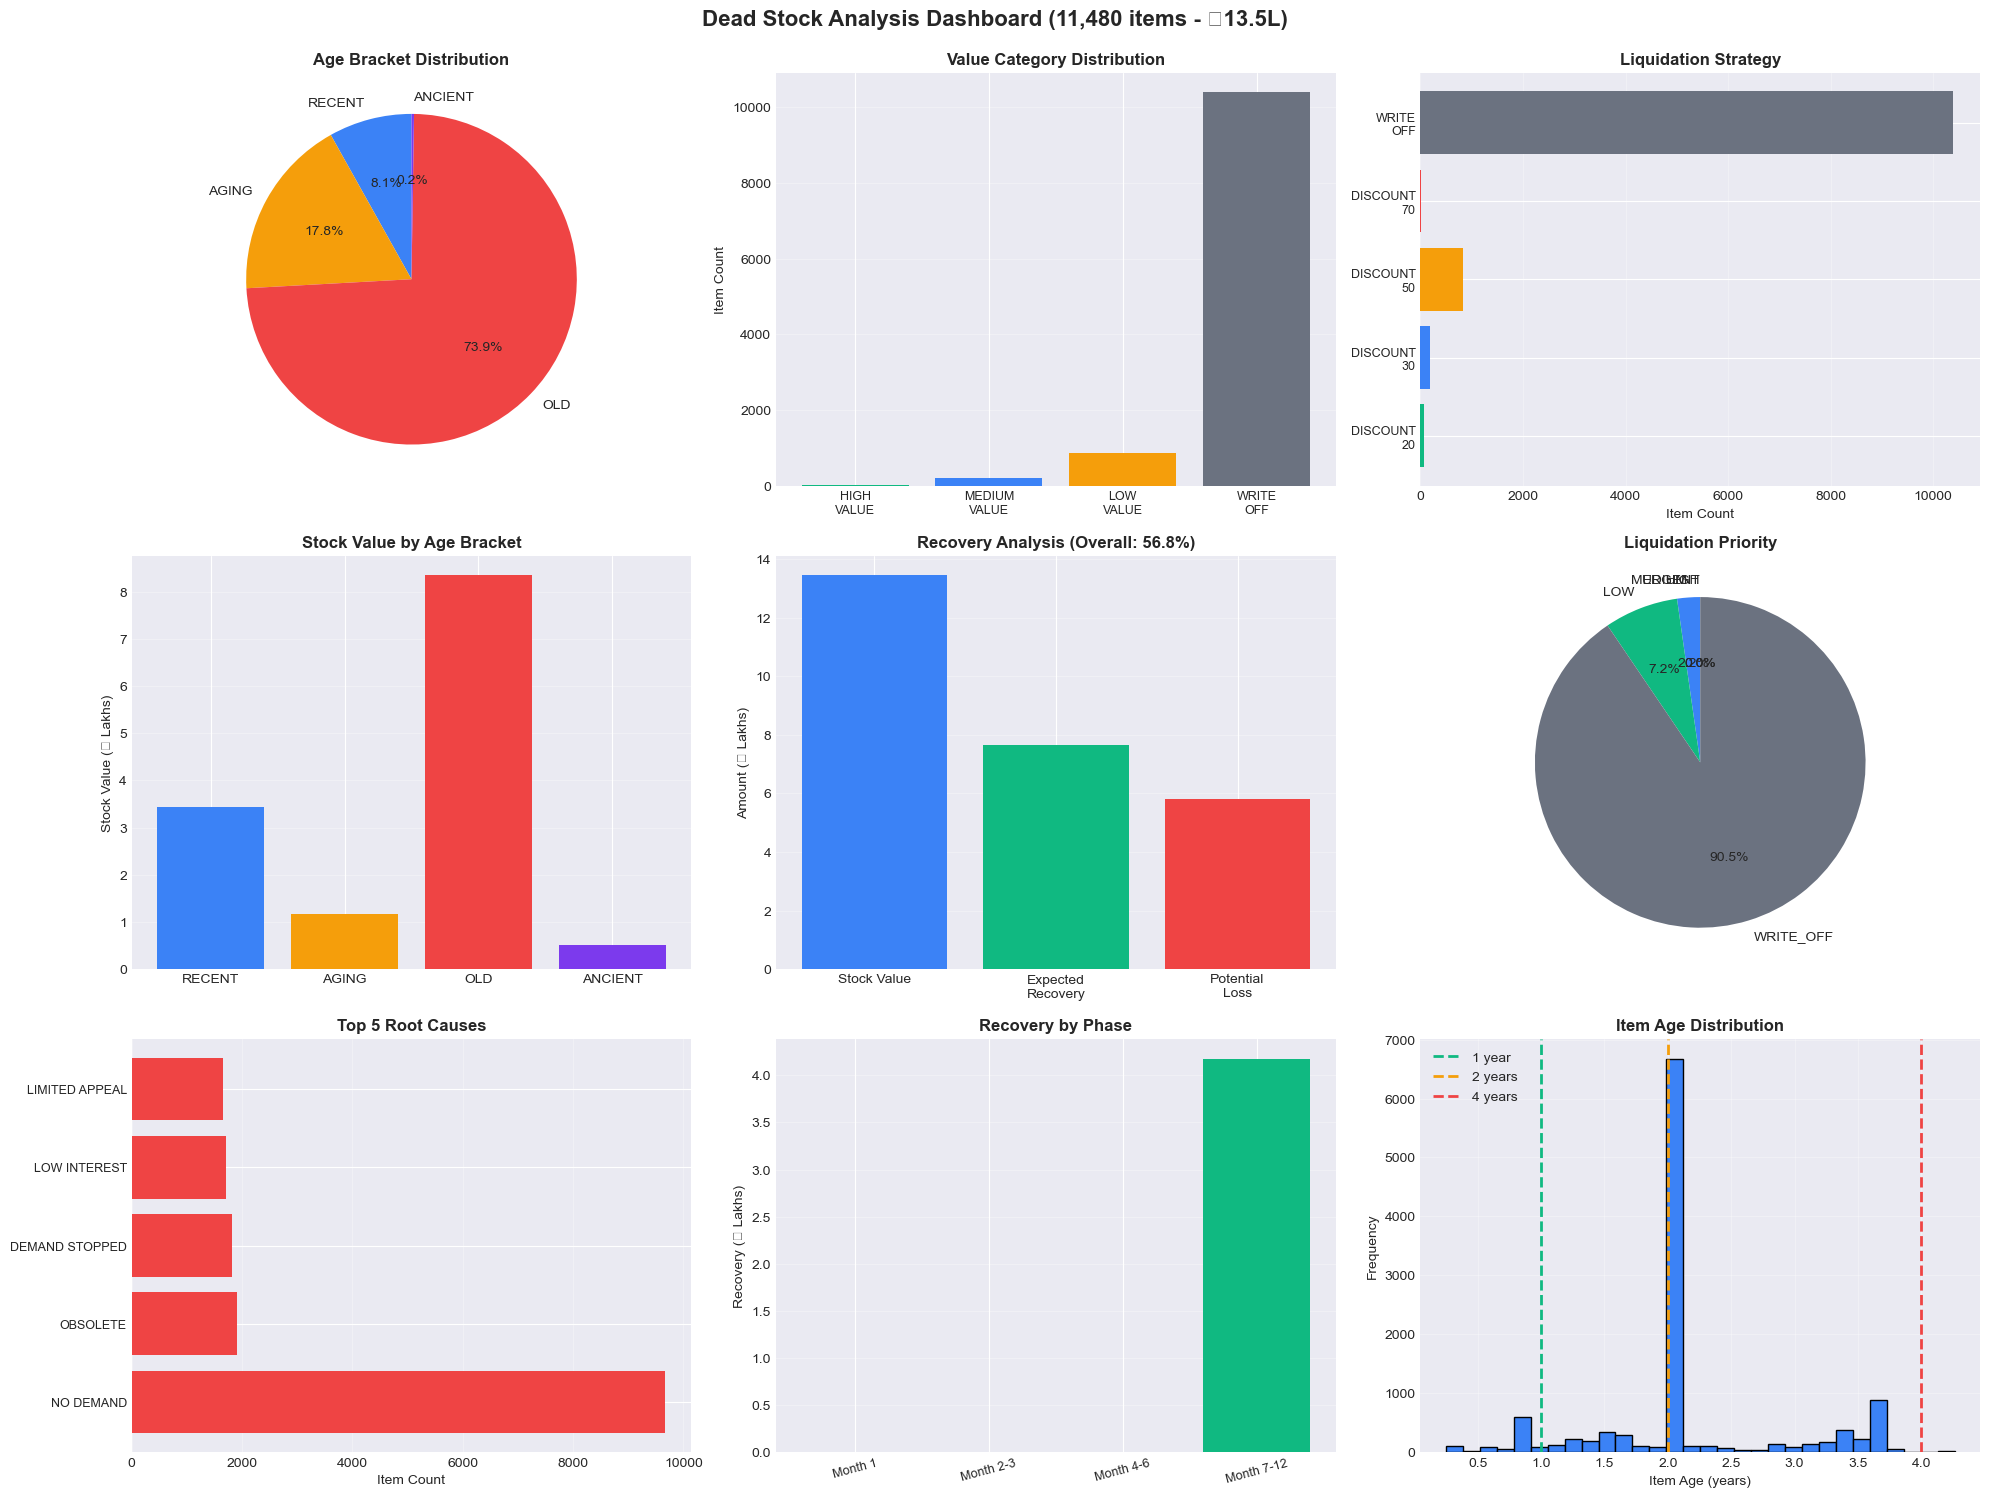


✅ Dashboard saved to /tmp/dead_stock_dashboard.png


In [10]:
if len(dead_stock) > 0:
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    
    colors_age = {'RECENT': '#3B82F6', 'AGING': '#F59E0B', 'OLD': '#EF4444', 'ANCIENT': '#7C3AED'}
    colors_priority = {'URGENT': '#EF4444', 'HIGH': '#F59E0B', 'MEDIUM': '#3B82F6', 
                      'LOW': '#10B981', 'WRITE_OFF': '#6B7280'}
    
    # 1. Age Bracket Distribution
    age_counts = dead_stock['age_bracket'].value_counts()
    age_order = ['RECENT', 'AGING', 'OLD', 'ANCIENT']
    age_counts = age_counts.reindex(age_order, fill_value=0)
    colors_list_age = [colors_age[k] for k in age_counts.index]
    
    axes[0, 0].pie(age_counts.values, labels=age_counts.index, autopct='%1.1f%%',
                   colors=colors_list_age, startangle=90)
    axes[0, 0].set_title('Age Bracket Distribution', fontsize=12, fontweight='bold')
    
    # 2. Value Category Distribution
    value_counts = dead_stock['value_category'].value_counts()
    value_order = ['HIGH_VALUE', 'MEDIUM_VALUE', 'LOW_VALUE', 'WRITE_OFF']
    value_counts = value_counts.reindex(value_order, fill_value=0)
    colors_value = ['#10B981', '#3B82F6', '#F59E0B', '#6B7280']
    
    axes[0, 1].bar(range(len(value_counts)), value_counts.values, color=colors_value)
    axes[0, 1].set_xticks(range(len(value_counts)))
    axes[0, 1].set_xticklabels([v.replace('_', '\n') for v in value_counts.index], fontsize=9)
    axes[0, 1].set_ylabel('Item Count')
    axes[0, 1].set_title('Value Category Distribution', fontsize=12, fontweight='bold')
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # 3. Liquidation Strategy Distribution
    strategy_counts = dead_stock['strategy'].value_counts()
    strategy_order = ['DISCOUNT_20', 'DISCOUNT_30', 'DISCOUNT_50', 'DISCOUNT_70', 'WRITE_OFF']
    strategy_counts = strategy_counts.reindex(strategy_order, fill_value=0)
    colors_strategy = ['#10B981', '#3B82F6', '#F59E0B', '#EF4444', '#6B7280']
    
    axes[0, 2].barh(range(len(strategy_counts)), strategy_counts.values, color=colors_strategy)
    axes[0, 2].set_yticks(range(len(strategy_counts)))
    axes[0, 2].set_yticklabels([s.replace('_', '\n') for s in strategy_counts.index], fontsize=9)
    axes[0, 2].set_xlabel('Item Count')
    axes[0, 2].set_title('Liquidation Strategy', fontsize=12, fontweight='bold')
    axes[0, 2].grid(axis='x', alpha=0.3)
    
    # 4. Stock Value by Age
    age_values = [dead_stock[dead_stock['age_bracket'] == age]['stock_value'].sum() / 100000
                 for age in age_order if age in dead_stock['age_bracket'].values]
    age_labels = [age for age in age_order if age in dead_stock['age_bracket'].values]
    colors_age_val = [colors_age[age] for age in age_labels]
    
    axes[1, 0].bar(range(len(age_labels)), age_values, color=colors_age_val)
    axes[1, 0].set_xticks(range(len(age_labels)))
    axes[1, 0].set_xticklabels(age_labels)
    axes[1, 0].set_ylabel('Stock Value (₹ Lakhs)')
    axes[1, 0].set_title('Stock Value by Age Bracket', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # 5. Recovery Potential
    categories = ['Stock Value', 'Expected\nRecovery', 'Potential\nLoss']
    values = [
        total_stock_value / 100000,
        total_expected_recovery / 100000,
        total_loss / 100000
    ]
    colors_recovery = ['#3B82F6', '#10B981', '#EF4444']
    
    axes[1, 1].bar(categories, values, color=colors_recovery)
    axes[1, 1].set_ylabel('Amount (₹ Lakhs)')
    axes[1, 1].set_title(f'Recovery Analysis (Overall: {overall_recovery_rate:.1f}%)', 
                         fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # 6. Liquidation Priority
    priority_counts = dead_stock['liquidation_priority'].value_counts()
    priority_order = ['URGENT', 'HIGH', 'MEDIUM', 'LOW', 'WRITE_OFF']
    priority_counts = priority_counts.reindex(priority_order, fill_value=0)
    colors_list_priority = [colors_priority[k] for k in priority_counts.index]
    
    axes[1, 2].pie(priority_counts.values, labels=priority_counts.index, autopct='%1.1f%%',
                  colors=colors_list_priority, startangle=90)
    axes[1, 2].set_title('Liquidation Priority', fontsize=12, fontweight='bold')
    
    # 7. Root Cause Analysis (Top 5)
    if all_causes:
        cause_counts = pd.Series(all_causes).value_counts().head(5)
        axes[2, 0].barh(range(len(cause_counts)), cause_counts.values, color='#EF4444')
        axes[2, 0].set_yticks(range(len(cause_counts)))
        axes[2, 0].set_yticklabels([c.replace('_', ' ') for c in cause_counts.index], fontsize=9)
        axes[2, 0].set_xlabel('Item Count')
        axes[2, 0].set_title('Top 5 Root Causes', fontsize=12, fontweight='bold')
        axes[2, 0].grid(axis='x', alpha=0.3)
    else:
        axes[2, 0].text(0.5, 0.5, 'No Root Causes', ha='center', va='center', fontsize=12)
        axes[2, 0].set_title('Top 5 Root Causes', fontsize=12, fontweight='bold')
    
    # 8. Recovery Timeline
    timeline_phases = action_plan['Phase'].str.split(' ').str[0:2].str.join(' ')
    timeline_recovery = action_plan['Expected_Recovery'] / 100000
    
    axes[2, 1].bar(range(len(timeline_phases)), timeline_recovery, color='#10B981')
    axes[2, 1].set_xticks(range(len(timeline_phases)))
    axes[2, 1].set_xticklabels(timeline_phases, fontsize=9, rotation=15)
    axes[2, 1].set_ylabel('Recovery (₹ Lakhs)')
    axes[2, 1].set_title('Recovery by Phase', fontsize=12, fontweight='bold')
    axes[2, 1].grid(axis='y', alpha=0.3)
    
    # 9. Item Age Distribution (Histogram)
    axes[2, 2].hist(dead_stock['item_age_years'], bins=30, color='#3B82F6', edgecolor='black')
    axes[2, 2].axvline(1, color='#10B981', linestyle='--', linewidth=2, label='1 year')
    axes[2, 2].axvline(2, color='#F59E0B', linestyle='--', linewidth=2, label='2 years')
    axes[2, 2].axvline(4, color='#EF4444', linestyle='--', linewidth=2, label='4 years')
    axes[2, 2].set_xlabel('Item Age (years)')
    axes[2, 2].set_ylabel('Frequency')
    axes[2, 2].set_title('Item Age Distribution', fontsize=12, fontweight='bold')
    axes[2, 2].legend()
    axes[2, 2].grid(alpha=0.3)
    
    plt.suptitle(f'Dead Stock Analysis Dashboard ({len(dead_stock):,} items - ₹{total_stock_value/100000:.1f}L)', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('/tmp/dead_stock_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Dashboard saved to /tmp/dead_stock_dashboard.png")

## 🔟 Save Results

In [11]:
if len(dead_stock) > 0:
    print("\n📤 SAVING DEAD STOCK ANALYSIS RESULTS...\n")
    
    # 1. Complete dead stock analysis
    dead_stock.to_csv('/tmp/dead_stock_complete.csv', index=False)
    print(f"✅ /tmp/dead_stock_complete.csv ({len(dead_stock):,} items)")
    
    # 2. Pickle
    dead_stock.to_pickle('/tmp/dead_stock_complete.pkl')
    print(f"✅ /tmp/dead_stock_complete.pkl")
    
    # 3. Liquidation plan (sorted by priority)
    liquidation_plan = dead_stock[
        dead_stock['strategy'] != 'WRITE_OFF'
    ][[
        'item_code', 'item_name', 'item_age_years', 'age_bracket',
        'stock_value', 'strategy', 'discount_pct', 'recovery_pct',
        'expected_recovery', 'liquidation_priority', 'priority_score',
        'timeframe_months', 'method', 'root_cause'
    ]].sort_values(['liquidation_priority', 'priority_score'], ascending=[True, False])
    
    liquidation_plan.to_csv('/tmp/liquidation_plan_priority.csv', index=False)
    print(f"✅ /tmp/liquidation_plan_priority.csv ({len(liquidation_plan):,} items)")
    
    # 4. Write-off candidates
    write_offs = dead_stock[dead_stock['strategy'] == 'WRITE_OFF'][[
        'item_code', 'item_name', 'stock_value', 'current_stock',
        'item_age_years', 'root_cause'
    ]]
    
    if len(write_offs) > 0:
        write_offs.to_csv('/tmp/write_off_candidates.csv', index=False)
        print(f"✅ /tmp/write_off_candidates.csv ({len(write_offs):,} items)")
    
    # 5. Root cause analysis
    root_cause_summary = dead_stock.groupby('root_cause').agg({
        'item_code': 'count',
        'stock_value': 'sum',
        'expected_recovery': 'sum'
    }).round(0)
    root_cause_summary.columns = ['Item_Count', 'Stock_Value', 'Expected_Recovery']
    root_cause_summary = root_cause_summary.sort_values('Item_Count', ascending=False)
    root_cause_summary.to_csv('/tmp/dead_stock_root_causes.csv')
    print(f"✅ /tmp/dead_stock_root_causes.csv")
    
    # 6. Action plan timeline
    action_plan.to_csv('/tmp/dead_stock_action_plan.csv', index=False)
    print(f"✅ /tmp/dead_stock_action_plan.csv")
    
    # 7. Executive summary
    summary_data = {
        'Metric': [
            'Total Dead Stock Items',
            'Total Stock Value',
            'Expected Recovery',
            'Recovery Rate',
            'Expected Loss',
            'Write-Off Items',
            'Write-Off Value',
            'URGENT Priority',
            'HIGH Priority',
            'MEDIUM Priority',
            'LOW Priority',
            'Avg Item Age (years)',
            'Items < 1 year',
            'Items > 4 years',
            'Annual Holding Cost',
            'Monthly Holding Cost'
        ],
        'Value': [
            len(dead_stock),
            f"₹{total_stock_value:,.0f}",
            f"₹{total_expected_recovery:,.0f}",
            f"{overall_recovery_rate:.1f}%",
            f"₹{total_loss:,.0f}",
            (dead_stock['strategy'] == 'WRITE_OFF').sum(),
            f"₹{dead_stock[dead_stock['strategy'] == 'WRITE_OFF']['stock_value'].sum():,.0f}",
            (dead_stock['liquidation_priority'] == 'URGENT').sum(),
            (dead_stock['liquidation_priority'] == 'HIGH').sum(),
            (dead_stock['liquidation_priority'] == 'MEDIUM').sum(),
            (dead_stock['liquidation_priority'] == 'LOW').sum(),
            f"{dead_stock['item_age_years'].mean():.1f}",
            (dead_stock['item_age_years'] < 1).sum(),
            (dead_stock['item_age_years'] > 4).sum(),
            f"₹{annual_holding_cost:,.0f}",
            f"₹{monthly_holding_cost:,.0f}"
        ]
    }
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv('/tmp/dead_stock_summary_report.csv', index=False)
    print(f"✅ /tmp/dead_stock_summary_report.csv")
    
    print("\n" + "="*100)
    print("✅ ALL FILES SAVED SUCCESSFULLY")
    print("="*100)
    
    print("\n📊 EXECUTIVE SUMMARY:")
    print(summary_df.to_string(index=False))

else:
    print("\n✅ No dead stock found - excellent inventory health!")


📤 SAVING DEAD STOCK ANALYSIS RESULTS...

✅ /tmp/dead_stock_complete.csv (11,480 items)
✅ /tmp/dead_stock_complete.pkl
✅ /tmp/liquidation_plan_priority.csv (1,088 items)
✅ /tmp/write_off_candidates.csv (10,392 items)
✅ /tmp/dead_stock_root_causes.csv
✅ /tmp/dead_stock_action_plan.csv
✅ /tmp/dead_stock_summary_report.csv

✅ ALL FILES SAVED SUCCESSFULLY

📊 EXECUTIVE SUMMARY:
                Metric      Value
Total Dead Stock Items      11480
     Total Stock Value ₹1,345,238
     Expected Recovery   ₹764,334
         Recovery Rate      56.8%
         Expected Loss   ₹580,905
       Write-Off Items      10392
       Write-Off Value    ₹43,166
       URGENT Priority          0
         HIGH Priority          0
       MEDIUM Priority        258
          LOW Priority        830
  Avg Item Age (years)        2.1
        Items < 1 year        932
       Items > 4 years         25
   Annual Holding Cost   ₹336,310
  Monthly Holding Cost    ₹28,026


## ✅ Summary

### Dead Stock Analysis Complete!

### Files Created:
1. **`dead_stock_complete.csv`** ⭐ (Complete analysis with 10+ new columns)
2. **`dead_stock_complete.pkl`** (Faster loading)
3. **`liquidation_plan_priority.csv`** (Sorted by recovery potential)
4. **`write_off_candidates.csv`** (Items < ₹100)
5. **`dead_stock_root_causes.csv`** (Why items died)
6. **`dead_stock_action_plan.csv`** (Month-by-month recovery plan)
7. **`dead_stock_summary_report.csv`** (Executive summary)
8. **`dead_stock_dashboard.png`** (9 comprehensive visualizations)

### New Columns Added:
- **item_age_years**: Age in years
- **age_bracket**: RECENT / AGING / OLD / ANCIENT
- **value_category**: HIGH_VALUE / MEDIUM_VALUE / LOW_VALUE / WRITE_OFF
- **strategy**: Liquidation strategy (DISCOUNT_20/30/50/70 or WRITE_OFF)
- **discount_pct**: Discount percentage
- **recovery_pct**: Expected recovery percentage
- **expected_recovery**: Amount recoverable (₹)
- **potential_loss**: Expected loss (₹)
- **timeframe_months**: Liquidation timeframe
- **method**: Liquidation method
- **priority_score**: Numerical priority score
- **liquidation_priority**: URGENT / HIGH / MEDIUM / LOW / WRITE_OFF
- **root_cause**: Why item became dead stock

### 🎉 ALL 5 NOTEBOOKS COMPLETE!

You now have a complete B2B inventory optimization system:
1. ✅ Master DataFrame Builder
2. ✅ DBSCAN Classification  
3. ✅ New Items Health Analysis
4. ✅ Demand Pattern & Order Quantity
5. ✅ Dead Stock Analysis (THIS ONE)

### Next Steps:
1. Run all notebooks sequentially
2. Import Material Requests into ERPNext
3. Begin liquidation campaign (Month 1: URGENT items)
4. Monitor recovery progress
5. Re-run monthly to track improvements